<a href="https://colab.research.google.com/github/nguyengiapphuongduy/ml-191/blob/master/linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

# Linear regression

### Calculate $\Phi$
Use polynomial to transform the features into non-linear, so $\phi_i(x) = x^i$. Thus:
$$
\mathbf{\Phi} =
\begin{pmatrix}
 \phi_0(\mathbf{x_1}) & \phi_1(\mathbf{x_1}) & \ldots & \phi_{M-1}(\mathbf{x_1})\\
 \phi_0(\mathbf{x_2}) & \phi_1(\mathbf{x_2}) & \ldots & \phi_{M-1}(\mathbf{x_2})\\
 \vdots      & \vdots      & \ddots & \vdots\\
 \phi_0(\mathbf{x_N}) & \phi_1(\mathbf{x_N}) & \ldots & \phi_{M-1}(\mathbf{x_N})
\end{pmatrix} =
\begin{pmatrix}
 1 & \mathbf{x_1} & \ldots & \mathbf{x_1}^{M-1}\\
 1 & \mathbf{x_2} & \ldots & \mathbf{x_2}^{M-1}\\
 \vdots      & \vdots      & \ddots & \vdots\\
 1 & \mathbf{x_N} & \ldots & \mathbf{x_N}^{M-1}\\
\end{pmatrix}
$$

### Calculate $\mathbf{W}_{ML}$ by
$$\mathbf{W}_{ML}=(\mathbf{\Phi}^T.\mathbf{\Phi})^{-1}.\mathbf{\Phi}^T.t$$

### Update $\mathbf{w}$ for Stochastic Gradient Descent by
$$\mathbf{w}^{(\tau+1)} = \mathbf{w}^{(\tau)} - \eta(\mathbf{w}^{(\tau)T}\mathbf{\Phi}_{n,:} - t_n)\mathbf{\Phi}_{n, :}$$

In [0]:
from IPython.display import clear_output

class MyLinearRegression():
    def __init__(self, max_degree=9, max_epoch=100000,
                 rate=0.1, tol=0.0001, gamma=0.9):
        # because we transform feature using polynomial,
        # we need one hyper-parameter, the degree M of the polynomial
        self.max_degree_ = max_degree
        self.max_epoch_ = max_epoch
        self.rate_ = rate
        self.tol_ = tol

    def _phi(self, m, x):
        """Transform feature"""
        return np.concatenate([np.array(x).reshape(-1, 1)**d for d in range(m)], axis=1)

    def _w(self, m, x, t):
        """Calculate w with the matmul solution"""
        phi = self._phi(m, x)
        return np.linalg.pinv(phi.T.dot(phi)).dot(phi.T).dot(t)

    def _sgd(self, m, x, t):
        """Learn w using Stochastic Gradient Descent"""
        # init
        w = np.random.randn(m)
        w1 = w + 1
        # SGD
        count, width = 0, 10
        for _ in range(self.max_epoch_):
            for i in np.random.permutation(x.shape[0]):
                # stop if w has no change in 'width' steps
                count = (count + 1) if np.linalg.norm(w - w1)/w.size < self.tol_ else 0
                if count >= width:
                    return w
                w1 = w
                # gradient descent
                phi = self._phi(m, x[i])
                grad = (w.dot(phi.ravel()) - t[i])*phi
                w = w - self.rate_*grad.ravel()
        return w

    def _rmse(self, w, x, t):
        """Evaluate the error using RMSE"""
        err = t - self._phi(w.size, x).dot(w)
        return np.sqrt(err.T.dot(err)/x.size)

    def fit(self, x, t, sgd=False, plot=True):
        x_train, x_validate, t_train, t_validate = self._split(x, t)
        w, m_axis, rmse_train, rmse_validate = [], [], [], []

        # Loop M from 1 to 10, choose the value that make the smallest RMSE
        # on the validation set.
        for m in np.arange(2, self.max_degree_ + 2):
            # Calculate W_ML
            if sgd:
                w.append(self._sgd(m, x_train, t_train))
            else:
                w.append(self._w(m, x_train, t_train))
            # train rmse
            rmse_train.append(self._rmse(w[-1], x_train, t_train))
            # validation rmse
            rmse_validate.append(self._rmse(w[-1], x_validate, t_validate))

            # print progress and plot
            m_axis.append(m)
            selected = np.argmin(np.array(rmse_validate))
            if plot:
                plt.figure(figsize=(10, 6))
                plt.plot(m_axis, rmse_train, 'o-r', label='RMSE on train')
                plt.plot(m_axis, rmse_validate, 'o-b', label='RMSE on validate')
                plt.scatter(m_axis[selected], rmse_validate[selected],
                            s=[100], c='g', marker='s', label='best RMSE')
                plt.legend()
                self._print_table(w, rmse_train, rmse_validate)
                plt.pause(0.01)
        # end for

        print('M = {}, RMSE = {}'.format(m_axis[selected], rmse_validate[selected]))
        self.w_ = w[selected]
        return self.w_
    
    def predict(self, x):
        return self._phi(self.w_.size, x).dot(self.w_)

    def _split(self, x, t):
        split = x.size//2
        indices = np.random.permutation(x.size)
        train_indices, validate_indices = indices[:split], indices[split:]
        return (x[train_indices], x[validate_indices],
                t[train_indices], t[validate_indices])

    def _print_table(self, w, train, validate):
        size = self.max_degree_ + 1
        output = ''
        TITLE_FORMAT = '{:>3s} | {:>9s} | {:>9s} | '
        TABLE_FORMAT = '{:3d} | {:9.2f} | {:9.2f} | '

        output += TITLE_FORMAT.format('M', 'train', 'validate')
        output += ''.join(['{:>12s} | '.format('w' + str(x)) for x in range(size)])
        output += ('\n' + '-'*(30 + 15*size))
        for i in range(len(w)):
            output += TABLE_FORMAT.format(len(w[i]), train[i], validate[i])
            output += ''.join(['{:12.2f} | '.format(x) for x in w[i]])
            output += '\n'
        clear_output(wait=True)
        print(output)
# end class

# Apply

### Generate Train set
Target function is $f(x) = sin(2\pi x)$

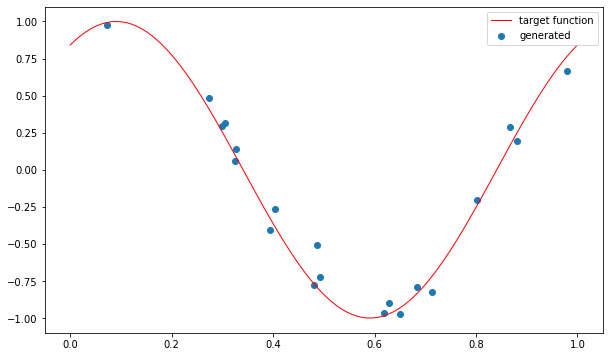

In [0]:
# range of x
left, right = 0, 1
# target function to predict
def f(x):
    return np.sin(x * np.pi*2 + 1)

class Data():
    def __init__(self, n):
        # uniform distribution for x
        self.x = np.random.uniform(left, right, n)
        # standard distribution for noise
        noise_t = np.random.randn(n)*0.1
        self.t = f(self.x).T + noise_t
        self.x = self.x.reshape(-1, 1)

train = Data(20)

# plot the target function
plt.figure(figsize=(10, 6))
plot_x = np.linspace(left, right, 100)
plot_t = f(plot_x)
plt.plot(plot_x, plot_t, '-r', linewidth=1, label='target function')
# plot the train and the validate set
plt.scatter(train.x, train.t, label='generated')
plt.legend()
pass

### Use matmul

  M |     train |  validate |           w0 |           w1 |           w2 |           w3 |           w4 |           w5 |           w6 |           w7 |           w8 |           w9 |          w10 | 
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  2 |      0.45 |      0.69 |         0.05 |        -0.73 | 
  3 |      0.10 |      0.75 |         4.47 |       -18.02 |        15.14 | 
  4 |      0.06 |      0.46 |         1.31 |         0.36 |       -17.80 |        18.55 | 
  5 |      0.06 |      0.46 |        -0.95 |        18.12 |       -67.56 |        77.75 |       -25.37 | 
  6 |      0.04 |      4.04 |        28.63 |      -267.10 |       991.53 |     -1820.39 |      1622.05 |      -555.71 | 
  7 |      0.04 |      5.19 |        37.99 |      -376.44 |      1508.48 |     -3088.35 |      3325.65 |     -1746.24 |       338.63 | 
  8 |      0.04 | 

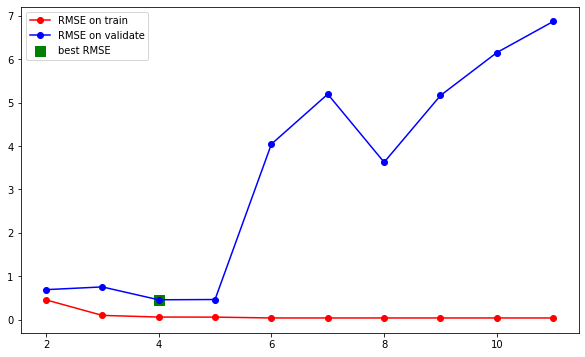

M = 4, RMSE = 0.45512946936290766


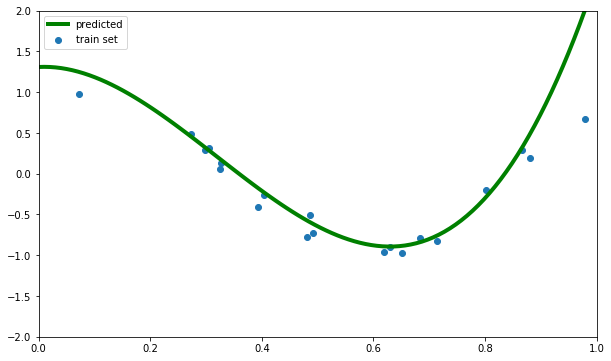

In [0]:
myLR = MyLinearRegression(max_degree=10)
myLR.fit(train.x, train.t, plot=True)

plt.figure(figsize=(10, 6))
plt.axis((0, 1, -2, 2)) #

# plot the train and validation set
plt.scatter(train.x, train.t, label='train set')

# plot the target and predicted function
plot_x = np.linspace(left, right, 100).reshape(-1, 1)
plot_pred = myLR.predict(plot_x)
plt.plot(plot_x, plot_pred, '-g', linewidth=4, label='predicted')

plt.legend()
pass

### Use SGD

M = 4, RMSE = 0.2063751321256952


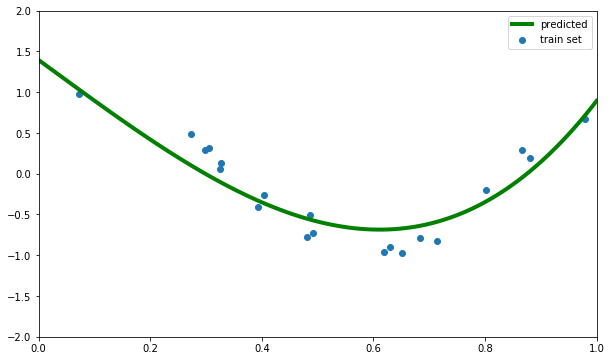

In [0]:
mySGD = MyLinearRegression(max_degree=10, rate=0.0015)
mySGD.fit(train.x, train.t, sgd=True, plot=False)

plt.figure(figsize=(10, 6))
plt.axis((0, 1, -2, 2)) #

# plot the train and validation set
plt.scatter(train.x, train.t, label='train set')

# plot the target and predicted function
plot_x = np.linspace(left, right, 100).reshape(-1, 1)
plot_pred = mySGD.predict(plot_x)
plt.plot(plot_x, plot_pred, '-g', linewidth=4, label='predicted')

plt.legend()
pass